# Imports

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os
# for dirname, _, filenames in os.walk('/kaggle/input/facial-age/face_age'):
#     print (dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)




Python 3.7.10
TensorFlow version: 2.6.0
Keras version: 2.6.0


In [3]:

INPUT_CLASSES_DIR = '/kaggle/input/facial-age/face_age/'

folders = glob(INPUT_CLASSES_DIR + '*')

ages_dict = {}

for dirname in folders:
    ages_dict[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

print ('Possible ages:')
ages_dict = dict(sorted(ages_dict.items()))
del[ages_dict['face_age']]

Possible ages:


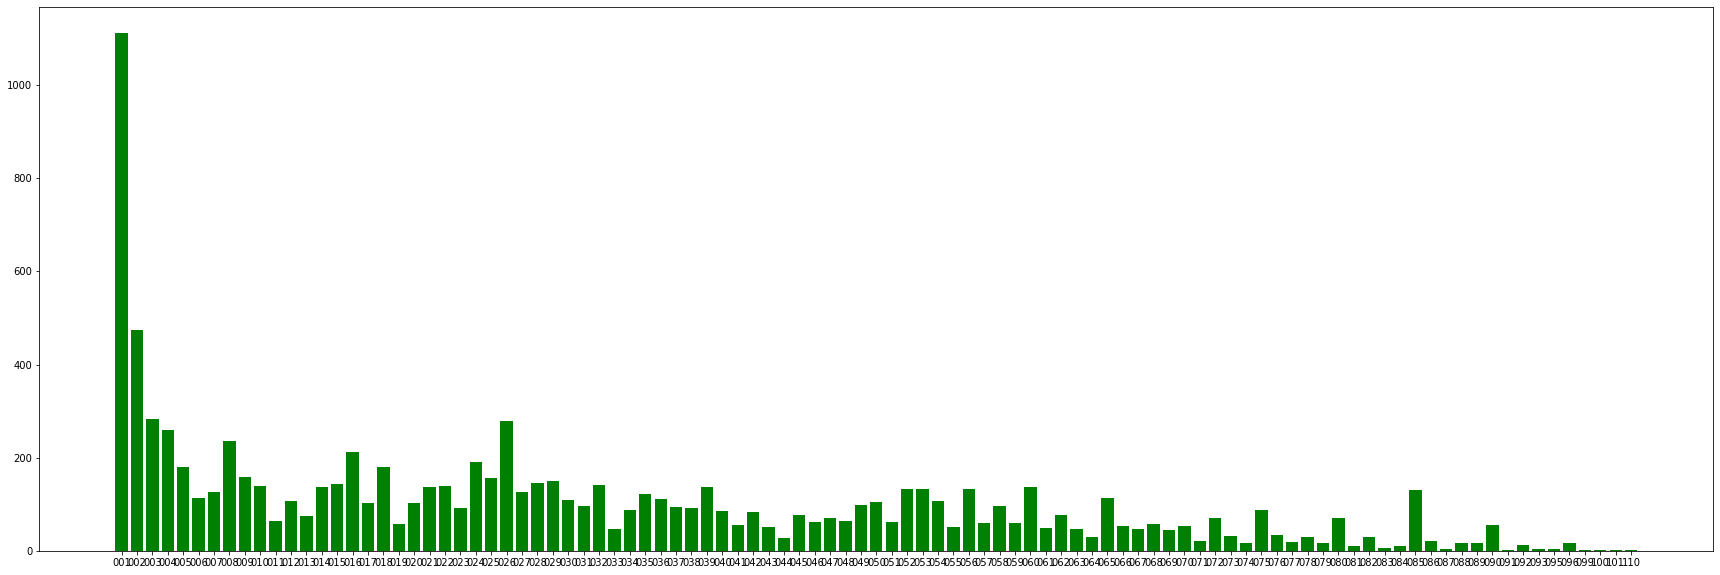

In [4]:
plt.figure(figsize=(30, 10))

plt.bar(list(ages_dict.keys()), ages_dict.values(), color='g')

plt.show()


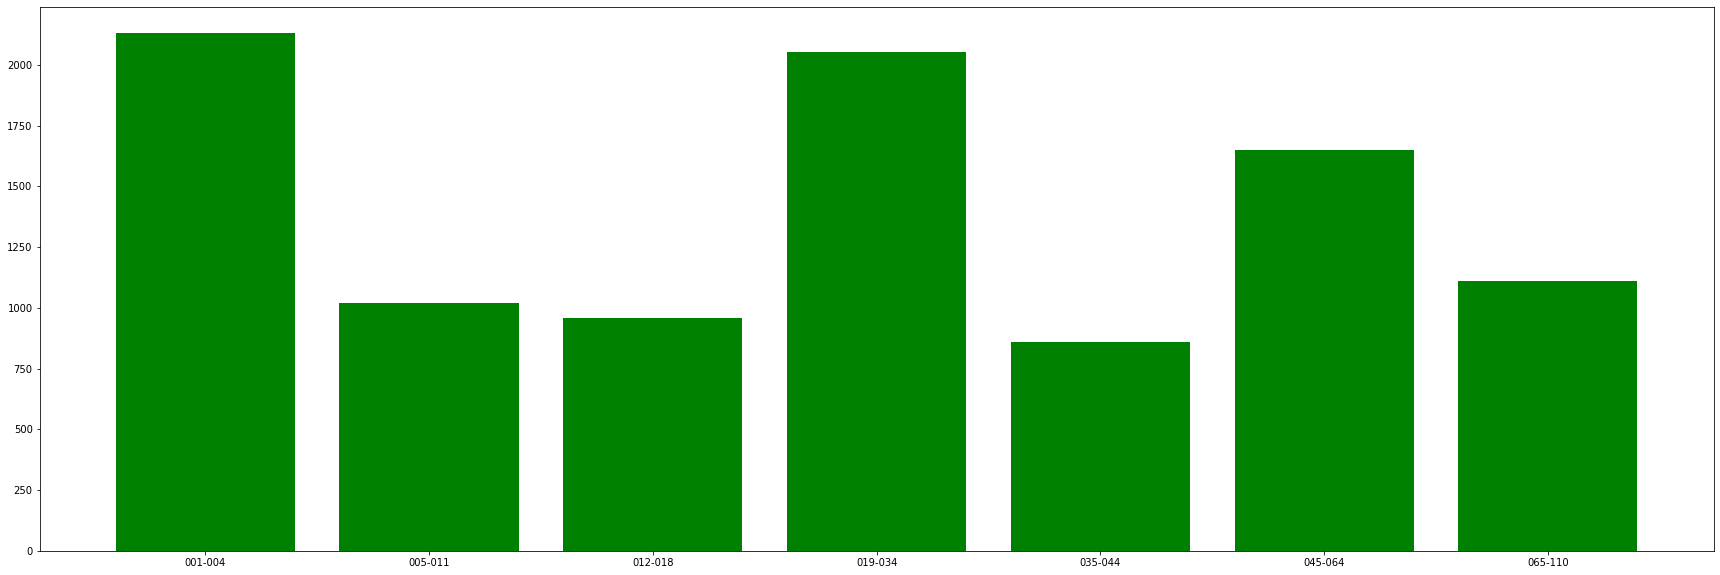

In [5]:
age_splits = [1,5,12,19,35,45,65,111]

age_splits_ranges = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]


age_groups = {}

for age_range in age_splits_ranges:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_groups[f'{age_range[0]}-{age_range[-1]}'] = total
    
#age_groups
plt.figure(figsize=(30, 10))

plt.bar(list(age_groups.keys()), age_groups.values(), color='g')

plt.show()


In [6]:
age_groups

{'001-004': 2131,
 '005-011': 1018,
 '012-018': 957,
 '019-034': 2055,
 '035-044': 858,
 '045-064': 1648,
 '065-110': 1111}

In [7]:
MIN_COUNT_IN_CLASS = min(age_groups.values())
#MIN_COUNT_IN_CLASS = 40
TRAIN_SAMPLE_SIZE = int(MIN_COUNT_IN_CLASS * 0.85 )
TEST_SAMPLE_SIZE = MIN_COUNT_IN_CLASS - TRAIN_SAMPLE_SIZE

In [8]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

age_groupped_filenames_dict = {}

for age_range in age_splits_ranges:
    Path(f"{test_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    age_groupped_filenames = []
    for age in age_range:
        full_dirname = INPUT_CLASSES_DIR + age
        age_groupped_filenames.extend(glob(full_dirname + '/*'))
    age_groupped_filenames_dict[f'{age_range[0]}-{age_range[-1]}'] = age_groupped_filenames
    
for age_range in age_groupped_filenames_dict:
    age_sample = random.sample(age_groupped_filenames_dict[age_range], MIN_COUNT_IN_CLASS)
    train_filenames = age_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{age_range}/{f.split('/')[-1]}")
        
    
    test_filenames = age_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{age_range}/{f.split('/')[-1]}")

In [9]:
# useful for getting number of files
train_files = glob(train_root + '/*/*.png')
test_files = glob(test_root + '/*/*.png')


In [10]:
print(len(train_files))
print(len(test_files))


5103
903


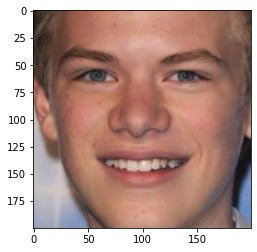

In [11]:
plt.imshow(image.load_img(np.random.choice(train_files)))

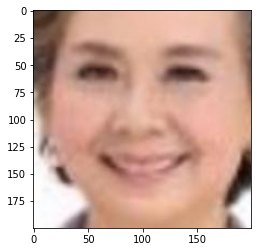

In [12]:
plt.imshow(image.load_img(np.random.choice(test_files)))


## For Resnet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100]

In [ ]:
# training config:
epochs = 20
batch_size = 128

### !! Only for the first time if you don't have h5 file

In [ ]:
# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

## For Xception

In [26]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [27]:
IMAGE_SIZE = [299, 299]

In [28]:
# training config:
epochs = 20
batch_size = 128

### !! Only for the first time if you don't have h5 file

In [ ]:
# Xception base
xception = Xception(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in xception.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(xception.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=xception.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## For MobileNetV3

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
IMAGE_SIZE = [224, 224]

### !! Only for the first time if you don't have h5 file

In [ ]:
# training config:
epochs = 20
batch_size = 128

In [ ]:
mobileNetV3Large = tf.keras.applications.MobileNetV3Large(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in mobileNetV3Large.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(mobileNetV3Large.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=mobileNetV3Large.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## InceptionResnetV2

In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [14]:
IMAGE_SIZE = [299, 299]

In [15]:
# training config:
epochs = 20
batch_size = 128

### !! Only for the first time if you don't have h5 file

In [31]:
inceptionResNetV2 = tf.keras.applications.InceptionResNetV2(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in inceptionResNetV2.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(inceptionResNetV2.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inceptionResNetV2.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

219070464/219055592 [==============================] - 10s 0us/step


## Rest of code for each solution

In [29]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [30]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 903 images belonging to 7 classes.
{'001-004': 0, '005-011': 1, '012-018': 2, '019-034': 3, '035-044': 4, '045-064': 5, '065-110': 6}


In [31]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 5103 images belonging to 7 classes.
Found 903 images belonging to 7 classes.


In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

In [ ]:
model.save('age_inceptionresnet.h5')
model.save_weights('age_inceptionresnet_weights.h5')

## Add pretrained model

In [32]:
from tensorflow.keras.models import load_model

In [33]:
model = load_model('/kaggle/input/h5file/age_Xception.h5')

In [34]:
from sklearn.metrics import mean_squared_error


# Faire des prédictions sur les données de validation
y_pred = model.predict(valid_generator)
y_true = valid_generator.classes

# Calculer la MSE
mse = mean_squared_error(y_true, y_pred.argmax(axis=1))

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.1107419712070874


In [35]:
def get_confusion_matrix(data_path, N):
    # Créer un générateur d'images pour les données de test
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = val_gen.flow_from_directory(
        data_path,
        target_size=IMAGE_SIZE,
        shuffle=False,
        batch_size=batch_size,
        class_mode='sparse'
    )
    
    # Prédire les étiquettes pour les données de test
    y_pred = model.predict(test_generator, steps=len(test_generator))
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Obtenir les étiquettes vraies
    y_true = test_generator.classes
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)
    return cm


In [36]:
cm = get_confusion_matrix(train_root, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(test_root, len(test_files))
print(valid_cm)

Found 5103 images belonging to 7 classes.
[[502 216   1   4   5   0   1]
 [ 23 510  69  34  60  31   2]
 [  5 142 295  95 116  76   0]
 [  3  26  68 267 272  92   1]
 [  0   7   5  68 527 116   6]
 [  0   8  10  26 284 368  33]
 [  2  12   5  15  77 264 354]]
Found 903 images belonging to 7 classes.
[[90 37  2  0  0  0  0]
 [ 3 95 11  5 10  5  0]
 [ 1 25 61 11 22  9  0]
 [ 1  5 12 56 39 16  0]
 [ 0  1  1 17 92 18  0]
 [ 2  5  1  4 36 74  7]
 [ 0  0  0  3 19 52 55]]


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[502 216   1   4   5   0   1]
 [ 23 510  69  34  60  31   2]
 [  5 142 295  95 116  76   0]
 [  3  26  68 267 272  92   1]
 [  0   7   5  68 527 116   6]
 [  0   8  10  26 284 368  33]
 [  2  12   5  15  77 264 354]]


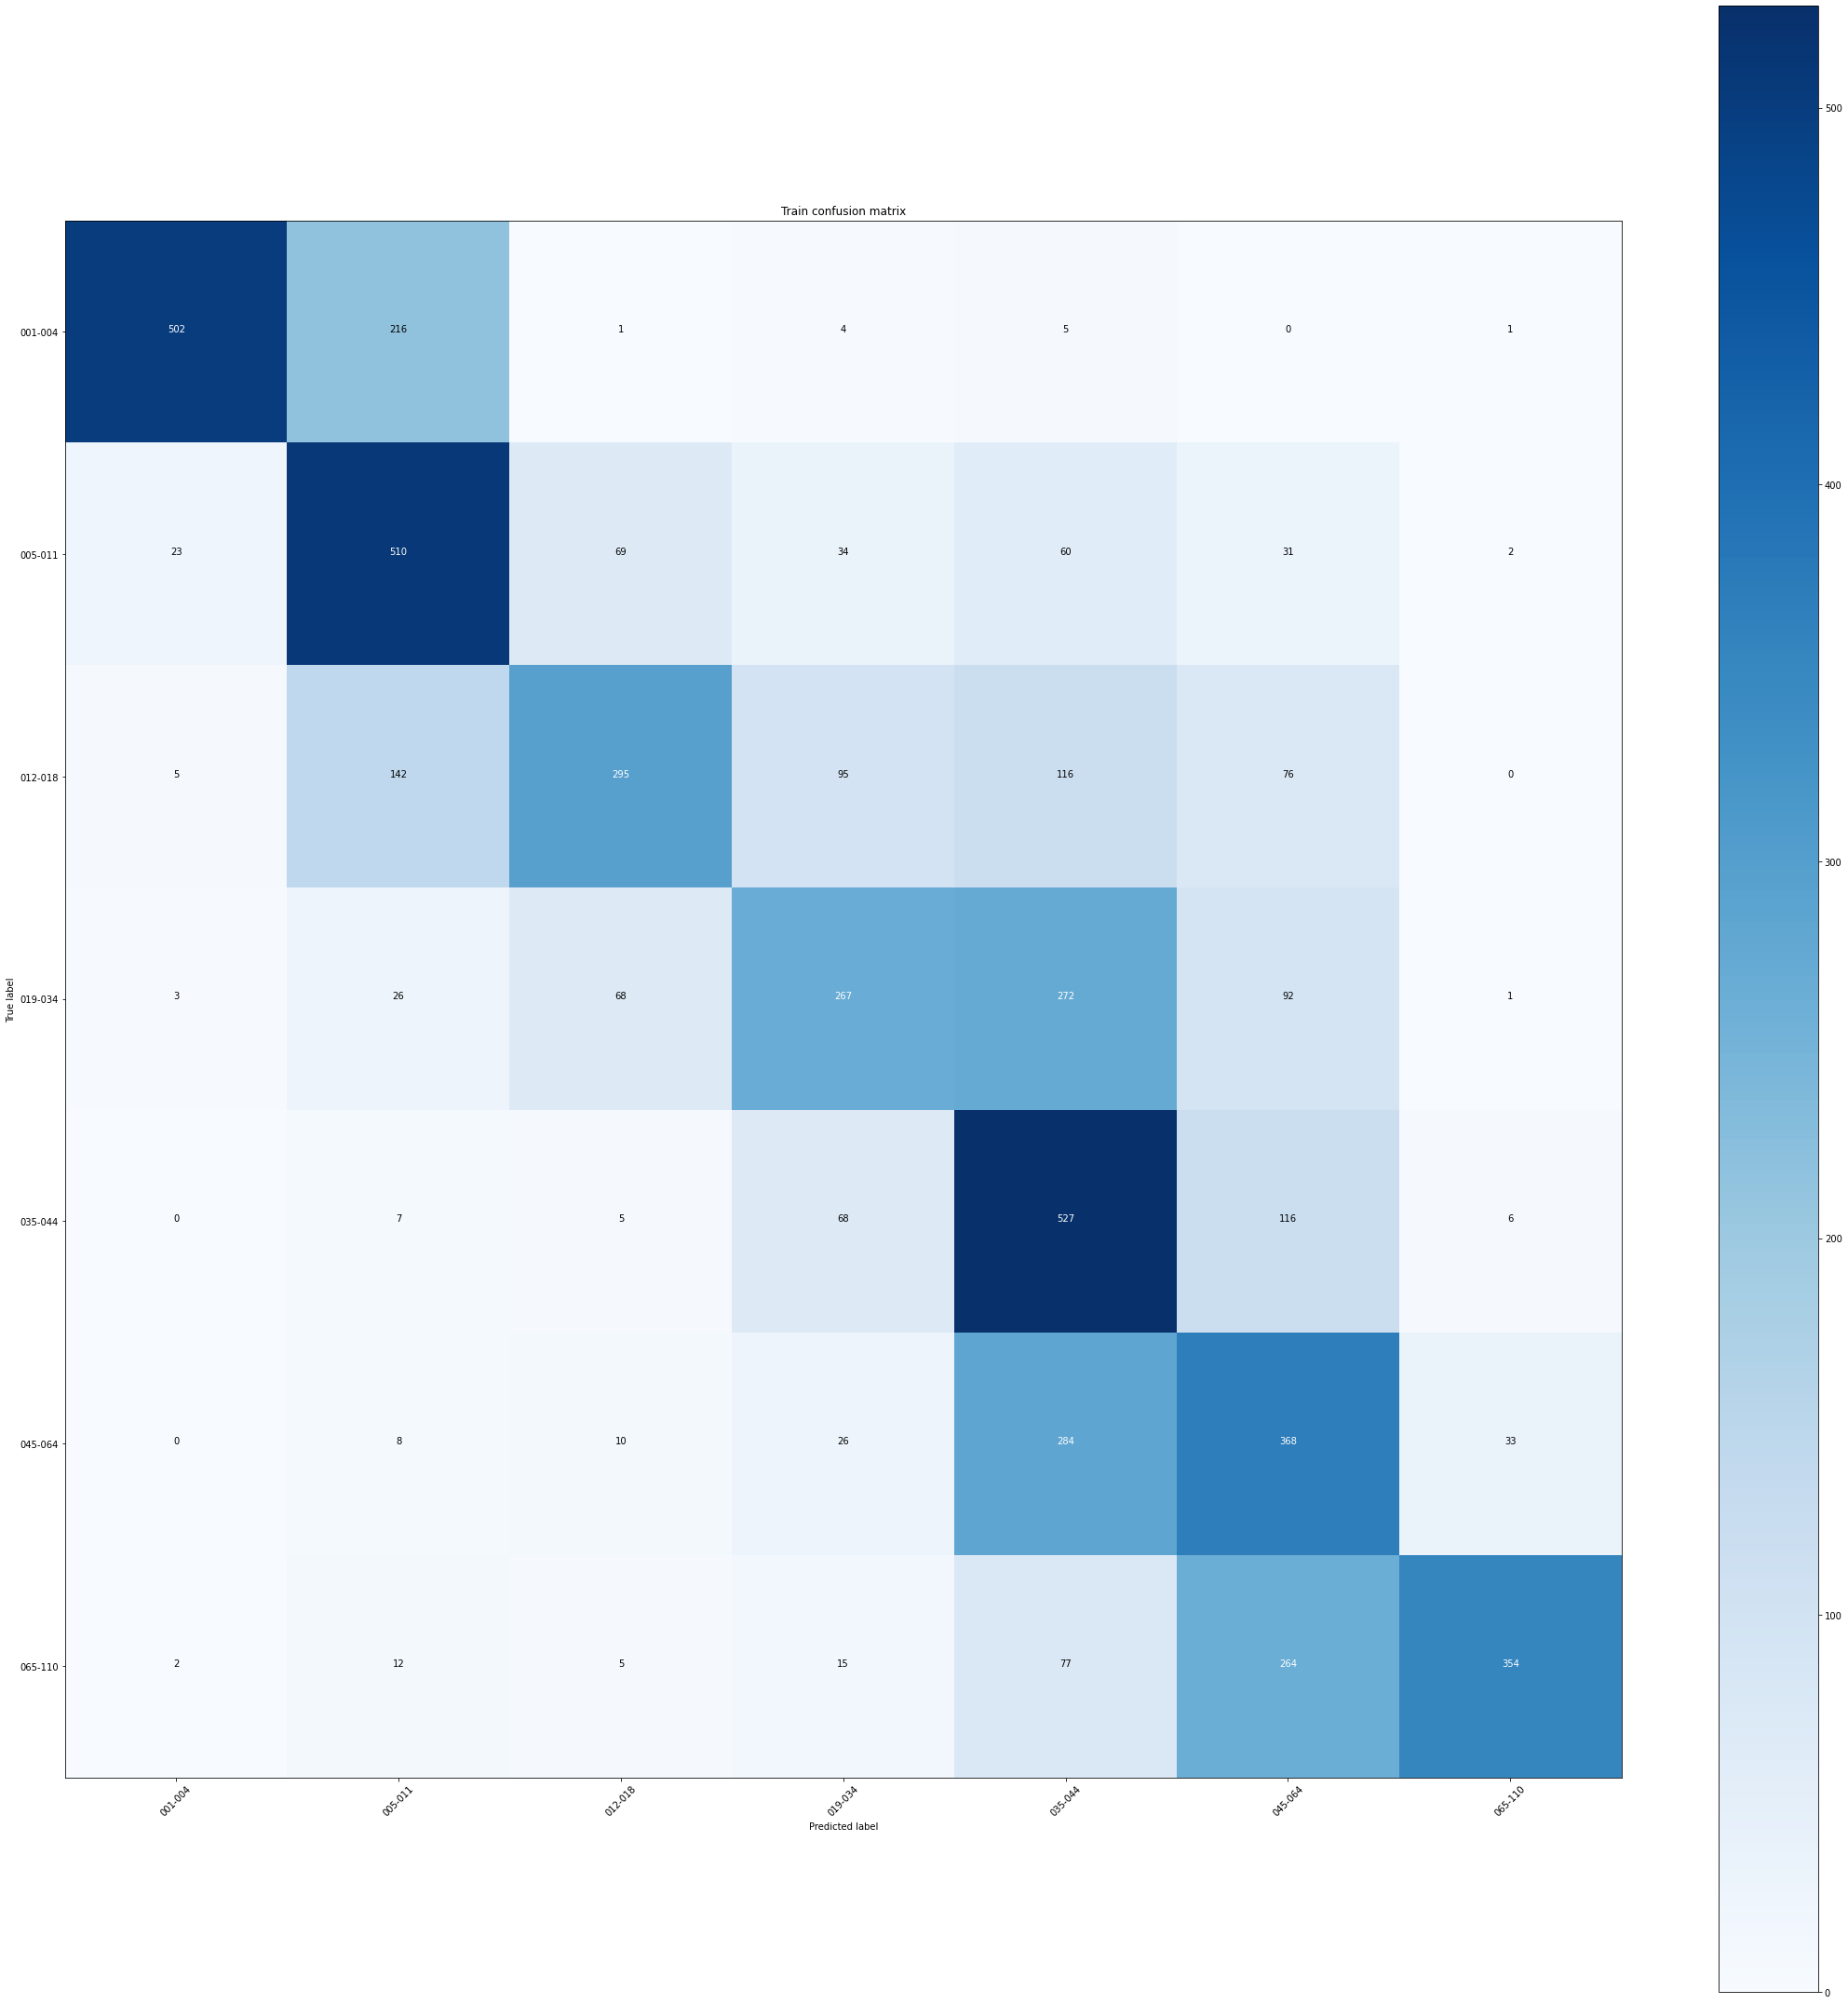

In [38]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


In [ ]:
import requests, io, cv2
import numpy as np
from PIL import Image


In [ ]:
URL = 'https://cdn.discordapp.com/attachments/1209703582841044992/1243523528024916070/IMG_20240524_191818.jpg?ex=66604988&is=665ef808&hm=042a07e2a7fa6c6fdad3302caacd06cd024ad95811f3b8cc50be4dbae2fd8a2c&'
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_RGB2BGR)

internal_image = cv2.resize(cv_im,IMAGE_SIZE)
internal_image = internal_image.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1],3) 


plt.imshow(internal_image[0])

In [ ]:
p = model.predict(internal_image)
#p = np.argmax(p)
pred_list = {x : float(y) for x,y in zip(labels, p[0])}
pred_list = dict(sorted(pred_list.items(), reverse=True, key=lambda item: item[1]))
pred_list